In [0]:
### LOAD DATA FROM GOOGLE DRIVE

# Install the PyDrive wrapper & import libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
folder_id='17ZHfezur8CY9XK4lfZ2b3o6jzfn3JsCo'
file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
print(file_list)


downloaded = drive.CreateFile({'id': folder_id})
downloaded.GetContentFile(downloaded['title'])

[]


In [3]:
!unzip pictures2.zip

Archive:  pictures2.zip
replace pictures/0205762611.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
import pandas as pd
import numpy as np

In [5]:
## Create dataframe
df = pd.read_csv('data.csv',encoding="latin")
df = df.drop("Unnamed: 0",axis=1)
print(df.shape)
df.head()

(36000, 8)


,index,img_idx,img_file,img_link,title,author,cat_id,category
0,56649,865717842,0865717842.jpg,http://ecx.images-amazon.com/images/I/51DqEOpN...,Real Goods Solar Living Sourcebook: Your Compl...,John Schaeffer,0,Arts & Photography
1,56533,415689317,0415689317.jpg,http://ecx.images-amazon.com/images/I/414gx4Qv...,Translucent Building Skins: Material Innovatio...,Scott Murray,0,Arts & Photography
2,56250,1565548310,1565548310.jpg,http://ecx.images-amazon.com/images/I/4173MVBP...,New Orleans Architecture: Faubourg TremÃÂ© an...,Roulhac Toledano,0,Arts & Photography
3,61325,3867878811,3867878811.jpg,http://ecx.images-amazon.com/images/I/51-JWrCa...,Sixty Nine: Joyful Gay Sex - Featuring Cockyboys,NaN,0,Arts & Photography
4,61280,133856887,0133856887.jpg,http://ecx.images-amazon.com/images/I/51tyyOiL...,"The Digital Photography Book, Part 5: Photo Re...",Scott Kelby,0,Arts & Photography


In [6]:
#What are our categories?
df.category.unique()

array(['Arts & Photography', 'Biographies & Memoirs', 'Business & Money',
       "Children's Books", 'Christian Books & Bibles',
       'Comics & Graphic Novels', 'Computers & Technology',
       'Cookbooks, Food & Wine', 'History', 'Humor & Entertainment',
       'Medical Books', 'Mystery, Thriller & Suspense',
       'Politics & Social Sciences', 'Religion & Spirituality', 'Romance',
       'Science & Math', 'Science Fiction & Fantasy', 'Sports & Outdoors'],
      dtype=object)

In [0]:
#given a class sample size, downsample classes that are smaller and then upsample classes that are bigger.
 sample_size = 100

from sklearn.utils import resample

resampled_df_list = []
for category, group in df.groupby('category'):
  replace = len(group) < sample_size
  df_group_resampled = resample(group, replace=replace, n_samples=sample_size, random_state=123)
  resampled_df_list.append(df_group_resampled)
    
df_resampled = pd.concat(resampled_df_list)

#refer to resampled dataset from now on
df=df_resampled

In [8]:
#verifying things were properly resampled
print('There are ', len(df_resampled.groupby('img_file').groups), ' unique image files in our resampled data')

#number of categories
print('There are ', len(df_resampled.groupby('category').groups), ' categories')

correct_size = True
for category, group in df_resampled.groupby('category'):
    if len(group) != sample_size:
        correct_size = False
    
print('Categories have the correct sample size: ', correct_size)

There are  1799  unique image files in our resampled data
There are  18  categories
Categories have the correct sample size:  True


In [0]:
#test train split the dataframe
from sklearn.model_selection import train_test_split
#Notice that we don't drop target from x_train, since we have to feed a dataframe with target
# to train_generator

target = df['category']
x_train, x_test, y_train, y_test = train_test_split(df, target, test_size=0.2)


#have to reset index of x_test so that can use image_data_generator on it ??
x_train = x_train.reset_index()
y_train = y_train.reset_index()
x_test = x_test.reset_index()
y_test = y_test.reset_index()

In [33]:
#TODO: use proper validation
from keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

directory = 'pictures/'

final_test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(x_test, directory, x_col='img_file', y_col='category', has_ext=True, target_size=(299, 299), batch_size=x_test.shape[0], color_mode='rgb', classes=None, class_mode='categorical', shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='jpeg', subset=None, interpolation='nearest')
test_imgs, test_labels = next(final_test_generator)

def build_generators(batch_size=128):
  train_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(x_train, directory, x_col='img_file', y_col='category', has_ext=True, target_size=(299, 299), color_mode='rgb', classes=None, class_mode='categorical', batch_size=batch_size, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='jpeg', subset=None, interpolation='nearest')
  test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(x_test, directory, x_col='img_file', y_col='category', has_ext=True, target_size=(299, 299), color_mode='rgb', classes=None, class_mode='categorical', batch_size=batch_size, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='jpeg', subset=None, interpolation='nearest')
  return {'train_generator': train_generator, 'test_generator': test_generator}


Found 341 images belonging to 18 classes.


In [0]:
num_classes = len(df.category.unique())

In [41]:
list(df.category.unique())

['Arts & Photography',
 'Biographies & Memoirs',
 'Business & Money',
 "Children's Books",
 'Christian Books & Bibles',
 'Comics & Graphic Novels',
 'Computers & Technology',
 'Cookbooks, Food & Wine',
 'History',
 'Humor & Entertainment',
 'Medical Books',
 'Mystery, Thriller & Suspense',
 'Politics & Social Sciences',
 'Religion & Spirituality',
 'Romance',
 'Science & Math',
 'Science Fiction & Fantasy',
 'Sports & Outdoors']

In [0]:
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

In [13]:
gen_dict = build_generators()

gen_dict['train_generator'].batch_size

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:2059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.df[x_col] = self.df[x_col].astype(str)


Found 1369 images belonging to 18 classes.
Found 341 images belonging to 18 classes.


128

In [0]:
import keras

In [0]:
from keras.applications import inception_v3

def build_model(num_classes=num_classes, dense_list=[(1024, 'relu')]):
  #initialise inception base model
  base_model=inception_v3.InceptionV3(weights='imagenet',include_top=False)

  x = base_model.output

  #add our architecture

  # add pooling layer
  x = GlobalAveragePooling2D()(x)
  
  # add fully-connected layers:
  for dense_layer in dense_list:
    num_neurons = dense_layer[0]
    print(num_neurons)
    activation = dense_layer[1]
    print(activation)
    x = Dense(num_neurons, activation=activation)(x)
    
  predictions = Dense(num_classes, activation='softmax')(x)

  # this is the model we will train
  model = Model(inputs=base_model.input, outputs=predictions)
  
  # turn off transfer layer training
  num_transfer_layers = len(base_model.layers)

  for layer in model.layers[:num_transfer_layers]:
    layer.trainable = False
  
  return model


In [0]:
from keras.optimizers import SGD, Adam

def param_search(model, train_params, train_generator, test_generator, optimizer_str='Adam', epochs=1):
  
  if optimizer_str == 'SGD':
    optimizer = keras.optimizers.SGD(lr=train_params['lr'])
  else:
    optimizer = keras.optimizers.Adam(lr=train_params['lr'])
  
  model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
  
  history = model.fit_generator(train_generator, validation_data=test_generator, 
                                steps_per_epoch=len(x_train)//train_generator.batch_size,
                                validation_steps=len(x_test)//test_generator.batch_size, use_multiprocessing=True,
                                epochs=epochs)
  
  return history
  
  

In [0]:
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix as cm
import seaborn as sn



def handle_metrics(history, name):
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  #plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')


  plt.savefig(str(name) + '.png')
  
def get_confusion_matrix(model, name):
  test_data = next(final_test_generator)
  y_preds = model.predict(test_data[0])
  predict_class = np.argmax(y_preds, axis=1)
  ground_truth = np.argmax(test_data[1], axis=1)
  c_matrix = cm(predict_class, ground_truth)
    
  df_cm = pd.DataFrame(c_matrix, index = list(df.category.unique()),
                  columns = list(df.category.unique()))
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True)
  plt.savefig('C_MATRIX' + str(name) + '.png')
 
  
  

In [18]:
batch_sizes = [128, 64]

architectures = []
architectures.append([(256, 'relu')])
architectures.append([(256, 'relu'), (256, 'relu')])
architectures.append([(512, 'relu')])
architectures.append([(1024, 'relu')])
architectures.append([(512, 'relu'), (256, 'relu')])
architectures.append([(512, 'relu'), (512, 'relu')])
architectures.append([(1024, 'relu'), (512, 'relu')])
architectures.append([(1024, 'relu'), (1024, 'relu')])
architectures.append([(256, 'sigmoid')])
architectures.append([(256, 'sigmoid'), (256, 'sigmoid')])
architectures.append([(512, 'sigmoid')])
architectures.append([(512, 'sigmoid'), (256, 'sigmoid')])
architectures.append([(512, 'relu'), (512, 'sigmoid')])
architectures.append([(1024, 'relu'), (512, 'sigmoid')])
architectures.append([(1024, 'relu'), (1024, 'sigmoid')])

lrs = [0.0001, 0.001, 0.01]
opts = ['Adam', 'SGD']

print(architectures)


[[(256, 'relu')], [(256, 'relu'), (256, 'relu')], [(512, 'relu')], [(1024, 'relu')], [(512, 'relu'), (256, 'relu')], [(512, 'relu'), (512, 'relu')], [(1024, 'relu'), (512, 'relu')], [(1024, 'relu'), (1024, 'relu')], [(256, 'sigmoid')], [(256, 'sigmoid'), (256, 'sigmoid')], [(512, 'sigmoid')], [(512, 'sigmoid'), (256, 'sigmoid')], [(512, 'relu'), (512, 'sigmoid')], [(1024, 'relu'), (512, 'sigmoid')], [(1024, 'relu'), (1024, 'sigmoid')]]


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:2059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.df[x_col] = self.df[x_col].astype(str)


Found 1369 images belonging to 18 classes.
Found 341 images belonging to 18 classes.
256
relu
Epoch 1/1
11/11 [==============================] - 34s 3s/step - loss: 2.9398 - acc: 0.0474 - val_loss: 2.9461 - val_acc: 0.0508
Epoch 1/1
11/11 [==============================] - 35s 3s/step - loss: 2.8542 - acc: 0.1252 - val_loss: 3.1256 - val_acc: 0.0625
Epoch 1/1
11/11 [==============================] - 35s 3s/step - loss: 11.5301 - acc: 0.0958 - val_loss: 14.0717 - val_acc: 0.0430
Epoch 1/1
11/11 [==============================] - 34s 3s/step - loss: 13.9139 - acc: 0.0897 - val_loss: 13.9876 - val_acc: 0.0430
Epoch 1/1
11/11 [==============================] - 35s 3s/step - loss: 13.7351 - acc: 0.1088 - val_loss: 13.8175 - val_acc: 0.0469
Epoch 1/1
11/11 [==============================] - 35s 3s/step - loss: 14.1993 - acc: 0.0846 - val_loss: 15.0072 - val_acc: 0.0312


KeyboardInterrupt: ignored

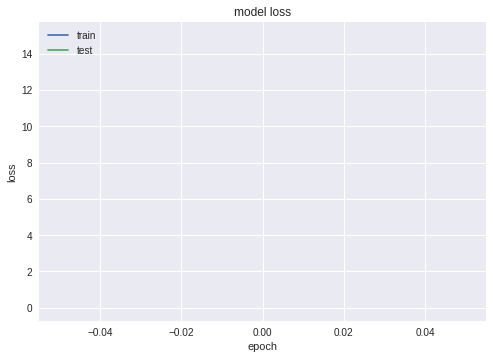

In [22]:
# DO GRID SEARCH OVER THESE PARAMS

#def param_search(model, train_params, optimizer_str='Adam', train_generator, test_generator, epochs=1):

EPOCHS = 1

for batch_size in batch_sizes:
  dict_gen = build_generators(batch_size=batch_size)
  train_generator = dict_gen['train_generator']
  test_generator = dict_gen['test_generator']
  
  for architecture in architectures:
    model = build_model(dense_list=architecture)
    
    for opt_str in opts:
      for lr in lrs:
        train_params = {'lr': lr}
        history = param_search(model, train_params, train_generator, test_generator, optimizer_str=opt_str, epochs=EPOCHS)
        
        name = 'ss-' + str(sample_size) + '_bs-' + str(batch_size) + '_arch-' + str(architecture) + '_opt-' + str(opt_str) + '_lr-' + str(lr) + '_epochs-' + str(EPOCHS)
        #name='test'
        name = name.replace('.', 'pt')
        name = name.replace('(', '')
        name = name.replace(')', '')
        name = name.replace('[', '')
        name = name.replace(',', '')
        name = name.replace(']', '')
        handle_metrics(model, history, name)

            
    

In [23]:
#number of epochs corresponds to one iteration through the entire dataset
EPOCHS = 1

model = build_model()
#just picked a random optimizer and loss function
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit_generator(train_generator, validation_data=test_generator, 
                    steps_per_epoch=len(x_train)//batch_size, 
                    validation_steps=len(x_test)//batch_size, use_multiprocessing=True,
                    epochs=EPOCHS)


1024
relu
Epoch 1/1
11/11 [==============================] - 38s 3s/step - loss: 3.1784 - acc: 0.0981 - val_loss: 3.0577 - val_acc: 0.0586


[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  0  4  2  3  4  2  0  2  5  2  3  0  4  2  2  0  5]
 [ 1  0  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  1  0]
 [ 1  0  1  4  2  1  0  1  1  1  0  1  0  2  0  0  0  1]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  1  0  3  0  5  1  6  0  6  3  0  3  3  3  1  1]
 [ 3  0  1  1  0  0  1  2  4  1  3  1  4  1  6  2  2  2]
 [ 1  1  2  4  1  6  1  1  4  2  2  1  2  4  1  4  3  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6 13  3  1  2  2  1  4  0  1  2  5  6  0  9  5  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 6  3  4 11  3 14  5  3  8  5

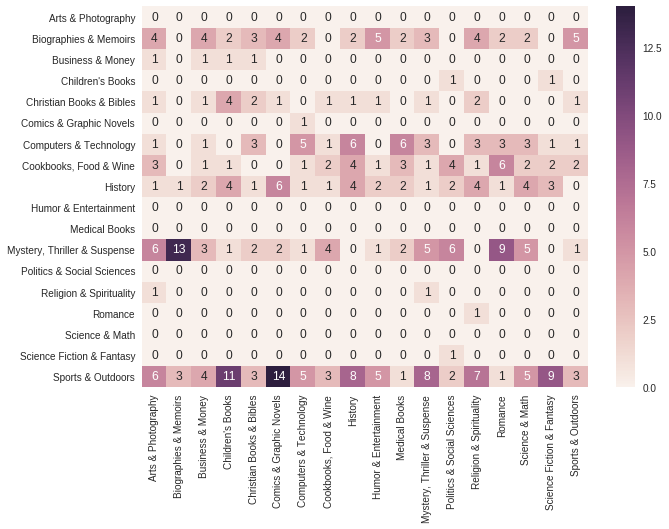

In [48]:

test_data = next(final_test_generator)
y_preds = model.predict(test_data[0])
predict_class = np.argmax(y_preds, axis=1)
ground_truth = np.argmax(test_data[1], axis=1)
c_matrix = cm(predict_class, ground_truth)

print(c_matrix)

get_confusion_matrix(model, 'test')

In [0]:
#TODO: get live training vs validation loss graph so we can visualise overfitting... and speed this up somehow! 
#TODO: tune hyperparameters to optimise for ... f1 score? probably.
#TODO: figure out how to actually use the model for prediction

In [0]:
import matplotlib.pyplot as plt

In [0]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()